<a href="https://colab.research.google.com/github/QuinnStraus/CSCI-1470-final/blob/main/DL_Final_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pypianoroll

     |████████████████████████████████| 5.6 MB 1.7 MB/s 
     |████████████████████████████████| 51 kB 6.4 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591953 sha256=6e92aded579b7b1e64607ec193b19591bba9f98ccae2544082c420b2858d62d9
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
import pypianoroll
import tensorflow as tf
import numpy as np
import os
import math

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
STOP_TOKEN = '<stop>'
PAD_TOKEN = '<pad>'


CHUNK_SZ = 1000
WINDOW_SZ = 100

In [ ]:
# Convert Text to array

text = []
root_dir = 'gdrive/Shared drives/CSCI1470 Final Project'
with open(os.path.join(root_dir, 'songs.txt'), 'r') as data_file:
  for line in data_file:
    text.append(line.replace("d", " d").split())
test_song = text[0]
text = text[1:]
print(text[0])


['br', 'd316', '35', 'd5', '47', 'd5', '54', 'd5', 'br', 'd4', '37', 'd5', '49', 'd5', '56', 'd5', 'br', 'd12', '35', 'd5', '47', 'd5', '54', 'd5', 'br', 'd4', '37', 'd5', '49', 'd5', '56', 'd5', 'br', 'd12', '35', 'd5', '47', 'd5', '54', 'd5', 'br', 'd4', '37', 'd5', '49', 'd5', '56', 'd5', 'br', 'd4', '48', 'd1', 'br', 'd1', '46', 'd2', '47', 'd1', 'br', 'd1', '45', 'd1', 'br', 'd1', '43', 'd2', '44', 'd1', 'br', 'd1', '42', 'd1', 'br', 'd1', '40', 'd2', '41', 'd1', 'br', 'd15', '49', 'd1', 'br', 'd1', '47', 'd2', '48', 'd1', 'br', 'd1', '46', 'd1', 'br', 'd1', '44', 'd2', '45', 'd1', 'br', 'd1', '43', 'd1', 'br', 'd1', '41', 'd2', '42', 'd1', 'br', 'd1', '40', 'd1', 'br', 'd1', '38', 'd2', '39', 'd1', 'br', 'd1', '29', 'd5', '41', 'd5', '48', 'd5', '53', 'd5', 'br', 'd4', '30', 'd29', '42', 'd29', '49', 'd25', '54', 'd37', 'br', 'd28', '31', 'd17', '43', 'd17', '55', 'd17', 'br', 'd16', '30', 'd13', '42', 'd13', '54', 'd5', 'br', 'd4', '49', 'd9', '55', 'd1', '56', 'd2', 'br', 'd1',

In [ ]:
# Transposes music to generate more data
transposed_songs = []
for song in text:
  for t in range(12):
    transp = []
    for note in song:
      if note[0] != 'b' and note[0] != 'd':
        transp.append(str(int(note) + t - 6))
      else:
        transp.append(note)
    transposed_songs.append(transp)


In [ ]:
print(len(transposed_songs))
print(str(int('1')+1))
print(transposed_songs[0])
print(transposed_songs[1])

29052
2
['br', 'd316', '35', 'd5', '47', 'd5', '54', 'd5', 'br', 'd4', '37', 'd5', '49', 'd5', '56', 'd5', 'br', 'd12', '35', 'd5', '47', 'd5', '54', 'd5', 'br', 'd4', '37', 'd5', '49', 'd5', '56', 'd5', 'br', 'd12', '35', 'd5', '47', 'd5', '54', 'd5', 'br', 'd4', '37', 'd5', '49', 'd5', '56', 'd5', 'br', 'd4', '48', 'd1', 'br', 'd1', '46', 'd2', '47', 'd1', 'br', 'd1', '45', 'd1', 'br', 'd1', '43', 'd2', '44', 'd1', 'br', 'd1', '42', 'd1', 'br', 'd1', '40', 'd2', '41', 'd1', 'br', 'd15', '49', 'd1', 'br', 'd1', '47', 'd2', '48', 'd1', 'br', 'd1', '46', 'd1', 'br', 'd1', '44', 'd2', '45', 'd1', 'br', 'd1', '43', 'd1', 'br', 'd1', '41', 'd2', '42', 'd1', 'br', 'd1', '40', 'd1', 'br', 'd1', '38', 'd2', '39', 'd1', 'br', 'd1', '29', 'd5', '41', 'd5', '48', 'd5', '53', 'd5', 'br', 'd4', '30', 'd29', '42', 'd29', '49', 'd25', '54', 'd37', 'br', 'd28', '31', 'd17', '43', 'd17', '55', 'd17', 'br', 'd16', '30', 'd13', '42', 'd13', '54', 'd5', 'br', 'd4', '49', 'd9', '55', 'd1', '56', 'd2', 'br

In [ ]:
# Pad songs
def pad_songs(songs):
  padded_songs = []
  for line in songs:
    if len(line) != 0:
      song = line[:CHUNK_SZ]
      song += [PAD_TOKEN] * (CHUNK_SZ - len(song))
      padded_songs.append(song)
  return padded_songs

orig = pad_songs(text)
transposed = pad_songs(transposed_songs)

In [ ]:
# Create vocab

tokens = []
for s in transposed: tokens.extend(s)
all_words = sorted(list(set([STOP_TOKEN,PAD_TOKEN] + tokens)))

vocab =  {word:i for i,word in enumerate(all_words)}
VOCAB_SZ = len(vocab)
print(VOCAB_SZ)

690


In [ ]:
orig_ids = np.asarray(np.stack([[vocab[word] for word in song] for song in orig]))
transposed_ids = np.asarray(np.stack([[vocab[word] for word in song] for song in transposed]))
test_ids = np.asarray(np.stack([vocab[word] for word in test_song]))

In [ ]:
print(orig_ids)
print(transposed_ids)

In [ ]:
# Transformer model
def Attention_Matrix(K, Q, use_mask=False):
	"""
	This functions runs a single attention head.
	:param K: is [batch_size x window_size_keys x embedding_size]
	:param Q: is [batch_size x window_size_queries x embedding_size]
	:return: attention matrix
	"""
	
	window_size_queries = Q.get_shape()[1] # window size of queries
	window_size_keys = K.get_shape()[1] # window size of keys
	root_dk = window_size_keys ** 0.5
	mask = tf.convert_to_tensor(value=np.transpose(np.tril(np.ones((window_size_queries,window_size_keys))*np.NINF,-1),(1,0)),dtype=tf.float32)
	atten_mask = tf.tile(tf.reshape(mask,[-1,window_size_queries,window_size_keys]),[tf.shape(input=K)[0],1,1])

	unmasked = tf.math.scalar_mul(root_dk, tf.matmul(Q, K, transpose_b=True))

	masked = tf.add(unmasked, atten_mask) if use_mask else unmasked
	return tf.nn.softmax(masked)


class Atten_Head(tf.keras.layers.Layer):
	def __init__(self, input_size, output_size, use_mask):		
		super(Atten_Head, self).__init__()

		self.use_mask = use_mask

		self.WK = self.add_weight(shape=(input_size, output_size), dtype=tf.float32, trainable=True)
		self.WQ = self.add_weight(shape=(input_size, output_size), dtype=tf.float32, trainable=True)
		self.WV = self.add_weight(shape=(input_size, output_size), dtype=tf.float32, trainable=True)
		
	@tf.function
	def call(self, inputs_for_keys, inputs_for_values, inputs_for_queries):

		"""
		:param inputs_for_keys: tensor of [batch_size x [ENG/FRN]_WINDOW_SIZE x input_size ]
		:param inputs_for_values: tensor of [batch_size x [ENG/FRN]_WINDOW_SIZE x input_size ]
		:param inputs_for_queries: tensor of [batch_size x [ENG/FRN]_WINDOW_SIZE x input_size ]
		:return: tensor of [BATCH_SIZE x (ENG/FRN)_WINDOW_SIZE x output_size ]
		"""

		K = tf.tensordot(inputs_for_keys, self.WK, axes=[[2], [1]])
		V = tf.tensordot(inputs_for_keys, self.WV, axes=[[2], [1]])
		Q = tf.tensordot(inputs_for_keys, self.WQ, axes=[[2], [1]])

		return tf.matmul(Attention_Matrix(K, Q, self.use_mask), V)

class Feed_Forwards(tf.keras.layers.Layer):
	def __init__(self, emb_sz):
		super(Feed_Forwards, self).__init__()

		self.layer_1 = tf.keras.layers.Dense(emb_sz,activation='relu')
		self.layer_2 = tf.keras.layers.Dense(emb_sz)

	@tf.function
	def call(self, inputs):
		layer_1_out = self.layer_1(inputs)
		layer_2_out = self.layer_2(layer_1_out)
		return layer_2_out

class Transformer_Block(tf.keras.layers.Layer):
	def __init__(self, emb_sz, is_decoder):
		super(Transformer_Block, self).__init__()

		self.ff_layer = Feed_Forwards(emb_sz)
		self.self_atten = Atten_Head(emb_sz,emb_sz,use_mask=is_decoder)
		self.is_decoder = is_decoder
		if self.is_decoder:
			self.self_context_atten = Atten_Head(emb_sz,emb_sz,use_mask=False)

		self.layer_norm = tf.keras.layers.LayerNormalization(axis=-1)

	@tf.function
	def call(self, inputs, context=None):

		atten_out = self.self_atten(inputs,inputs,inputs)
		atten_out+=inputs
		atten_normalized = self.layer_norm(atten_out)

		if self.is_decoder:
			assert context is not None,"Decoder blocks require context"
			context_atten_out = self.self_context_atten(context,context,atten_normalized)
			context_atten_out+=atten_normalized
			atten_normalized = self.layer_norm(context_atten_out)

		ff_out=self.ff_layer(atten_normalized)
		ff_out+=atten_normalized
		ff_norm = self.layer_norm(ff_out)

		return tf.nn.relu(ff_norm)

class Position_Encoding_Layer(tf.keras.layers.Layer):
	def __init__(self, window_sz, emb_sz):
		super(Position_Encoding_Layer, self).__init__()
		self.positional_embeddings = self.add_weight("pos_embed",shape=[window_sz, emb_sz])

	@tf.function
	def call(self, x):
		"""
		Adds positional embeddings to word embeddings.    
		:param x: [BATCH_SIZE x (ENG/FRN)_WINDOW_SIZE x EMBEDDING_SIZE ] the input embeddings fed to the encoder
		:return: [BATCH_SIZE x (ENG/FRN)_WINDOW_SIZE x EMBEDDING_SIZE ] new word embeddings with added positional encodings
		"""
		return x+self.positional_embeddings

class Transformer_Seq2Seq(tf.keras.Model):
	def __init__(self, window_sz, vocab_sz):
		super(Transformer_Seq2Seq, self).__init__()

		self.vocab_sz = vocab_sz
		self.window_sz = window_sz 

		# Define batch size and optimizer/learning rate
		self.batch_size = 50
		self.embedding_size = 128
		self.learning_rate = 0.0015
		self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

		# Define english and french embedding layers:
		self.embedding = tf.keras.layers.Embedding(self.vocab_sz, self.embedding_size)
		# Create positional encoder layers
		self.position = Position_Encoding_Layer(self.window_sz, self.embedding_size)
		# Define encoder and decoder layers:
		self.encoder = Transformer_Block(self.embedding_size, False)
		self.decoder = Transformer_Block(self.embedding_size, True)
		# Define dense layer(s)
		self.dense1 = tf.keras.layers.Dense(5, activation='relu')
		self.dense2 = tf.keras.layers.Dense(self.vocab_sz, activation='softmax')

	@tf.function
	def call(self, encoder_input, decoder_input):
		"""
		:param encoder_input: batched ids corresponding to french sentences
		:param decoder_input: batched ids corresponding to english sentences
		:return prbs: The 3d probabilities as a tensor, [batch_size x window_size x english_vocab_size]
		"""

		#1) Add the positional embeddings to french sentence embeddings
		located_given = self.position(self.embedding(encoder_input))
		#2) Pass the french sentence embeddings to the encoder
		encoded = self.encoder(located_given)
		#3) Add positional embeddings to the english sentence embeddings
		located_wanted = self.position(self.embedding(decoder_input))
		#4) Pass the english embeddings and output of your encoder, to the decoder
		decoded = self.decoder(located_wanted, encoded)
		#5) Apply dense layer(s) to the decoder out to generate probabilities
		probabilities = self.dense2(self.dense1(decoded))
		return probabilities

	def loss(self, probs, labels):
					return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, probs))
		
def train(model, inputs):
	"""
	Inputs: list of sequence of notes as tokens
	"""
	unshuffled_inputs = []
	sequed = []
	def seq_window(sequences, window_size):
		data = []
		for ind in range(len(sequences)):
			seq_len = len(sequences[ind])
			if seq_len < window_size:
				raise Exception("Window too large for sequence")
			windows = []
			for window in range(seq_len - window_size + 1):
				windows.append((ind, window))
			data += windows
		return data
	
	def to_window(bat, inputs, is_label):
		new_windows = np.zeros([model.batch_size, WINDOW_SZ])
		for i in range(len(bat)):
			inds = bat[i]
			seq = inputs[inds[0]]
			
			if is_label:
				new_windows[i] = seq[inds[1]+1:inds[1]+1+WINDOW_SZ]
			else:
				new_windows[i] = seq[inds[1]:inds[1]+WINDOW_SZ]
		return new_windows

	unshuffled_inputs = seq_window(inputs[:, :-1], WINDOW_SZ)
	print(unshuffled_inputs[0])
	indices = np.arange(len(unshuffled_inputs))
	np.random.shuffle(indices)

	sequed = np.take(np.asarray(unshuffled_inputs), indices, axis=0)
	print(sequed[0])
	lass = 0
	losses = []
	for batch in range(math.floor(len(inputs) / model.batch_size)):
		batch_1 = sequed[batch * model.batch_size:batch * model.batch_size + model.batch_size]
		batch_en_in = to_window(batch_1, inputs, False)
		batch_de_la = to_window(batch_1, inputs, True)

		if batch%20 == 0:
			print(lass / 20)
			lass = 0
		else:
			pass	
		with tf.GradientTape() as tape:
			predictions = model.call(batch_en_in, batch_en_in)
			loss = model.loss(predictions, batch_de_la)
			lass += loss
			losses.append(loss)
			gradients = tape.gradient(loss, model.trainable_variables)
			model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
	return losses

def generate_sentence(sample, length, vocab, model, sample_n=10):
	reverse_vocab = {idx: word for word, idx in vocab.items()}
	notes = [sample]
	next_input = np.asarray([sample])
	song = np.asarray([sample])

	for i in range(length):
		logits = model.call(next_input, next_input)
		logits = np.array(logits[0, WINDOW_SZ - 1,:])
		top_n = np.argsort(logits)[-sample_n:]			
		n_logits = np.exp(logits[top_n])/np.exp(logits[top_n]).sum()
		out_index = np.random.choice(top_n,p=n_logits)
		song = np.append(song, [[out_index]], axis=1)
		next_input = np.append(next_input[:, 1:], [[out_index]], axis=1)

	return song

model = Transformer_Seq2Seq(WINDOW_SZ, VOCAB_SZ)

(0, 0)
[6198   51]
0.0
tf.Tensor(6.0327487, shape=(), dtype=float32)
tf.Tensor(4.7893343, shape=(), dtype=float32)
tf.Tensor(4.0625277, shape=(), dtype=float32)
tf.Tensor(3.7544446, shape=(), dtype=float32)
tf.Tensor(3.5167038, shape=(), dtype=float32)
tf.Tensor(3.3086681, shape=(), dtype=float32)
tf.Tensor(3.210307, shape=(), dtype=float32)
tf.Tensor(3.1542475, shape=(), dtype=float32)
tf.Tensor(3.089437, shape=(), dtype=float32)
tf.Tensor(3.0790467, shape=(), dtype=float32)
tf.Tensor(3.0321348, shape=(), dtype=float32)
tf.Tensor(3.03453, shape=(), dtype=float32)
tf.Tensor(3.0127358, shape=(), dtype=float32)
tf.Tensor(3.017417, shape=(), dtype=float32)
tf.Tensor(3.0069475, shape=(), dtype=float32)
tf.Tensor(3.0047174, shape=(), dtype=float32)
tf.Tensor(3.0039973, shape=(), dtype=float32)
tf.Tensor(3.0064929, shape=(), dtype=float32)
tf.Tensor(3.0222945, shape=(), dtype=float32)
tf.Tensor(3.0217137, shape=(), dtype=float32)
tf.Tensor(2.9608958, shape=(), dtype=float32)
tf.Tensor(2.9752

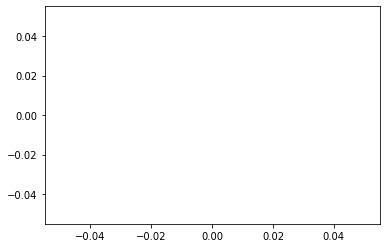

In [ ]:
from matplotlib import pyplot as plt
losses = []
for i in range(1):
  losses += train(model, transposed_ids)
for i in range(3):
 losses += train(model, orig_ids)
plt.plot()
plt.show(losses)

In [ ]:
sample = orig_ids[1986, 30:130]
reverse_vocab = {idx: word for word, idx in vocab.items()}
string = ""
for id in generate_sentence(sample, 400, vocab, model).tolist()[0]:
  string += str(reverse_vocab[id]) + " "

print(string)

47 d5 br d3 57 d6 br d1 45 d5 br d3 56 d5 br d1 44 d5 br d3 54 d3 br d1 42 d6 57 d63 61 d127 66 d63 br d4 54 d2 br d4 37 d6 54 d3 br d2 53 d3 br d2 54 d2 br d2 56 d3 br d2 42 d5 br d6 37 d7 br d4 56 d3 br d2 40 d5 br d2 59 d3 br d2 42 d7 br d8 37 d6 br d8 42 d7 62 d4 br d4 60 d3 br d2 37 d7 br d4 56 d3 60 d11 55 d7 br d6 67 d7 62 d1 69 d3 62 d9 br d2 52 d6 55 d6 br d2 59 d4 62 d10 60 d2 59 d3 64 d4 33 d2 57 d3 55 d2 59 d10 57 d1 55 d2 55 d3 60 d11 55 d5 69 d2 59 d9 60 d10 57 d7 62 d7 69 d3 62 d4 38 d9 60 d4 67 d11 59 d1 36 d4 52 d17 69 d4 64 d1 57 d7 67 d3 64 d4 33 d8 62 d3 br d7 57 d9 60 d6 67 d9 64 d9 br d16 67 d1 57 d2 60 d5 67 d5 69 d9 br d3 br d2 60 d2 52 d1 59 d10 64 d10 67 d1 64 d8 57 d4 62 d11 br d3 67 d3 br d2 62 d8 31 d3 57 d17 57 d5 57 d9 59 d13 59 d3 br d10 57 d9 br d5 62 d4 64 d13 59 d17 60 d5 69 d2 55 d5 55 d3 59 d9 60 d7 71 d7 59 d2 55 d4 52 d6 67 d10 55 d3 64 d2 57 d5 69 d2 57 d6 br d3 55 d1 52 d1 52 d3 64 d11 br d12 52 d8 59 d3 71 d4 33 d17 57 d7 55 d1 br d2 br d6 60 d

In [ ]:
reverse_vocab = {idx: word for word, idx in vocab.items()}
for id in song_ids[0, :20]: print(reverse_vocab[id]) 

NameError: ignored

In [ ]:
# Takes in a string of tokens representing one song, transforms into a pianoroll matrix
def token_to_music(tokens):
  token_list = tokens.replace(" d", "d").split()
  mat = np.full([1, 128], False)
  note = 0
  for tk in token_list:
    pitch_dur = tk.split('d')
    if len(pitch_dur) == 2:
      pitch = tk.split('d')[0]
      dur = int(tk.split('d')[1])
      if pitch == 'br':
        note += dur
      else:
        for i in range(dur):
          while note + i >= mat.shape[0]:
            mat = np.append(mat, np.full([1, 128], False), axis = 0)
          mat[note + i, int(pitch)] = True
  return mat

track = pypianoroll.BinaryTrack(pianoroll=token_to_music(string)) #fill in "" with tokens 
                                
pypianoroll.write(os.path.join(root_dir, "test_output3.mid"), pypianoroll.Multitrack(resolution = 8, tempo = np.full([200, 1], 120), tracks = [track]))

token_to_music(string)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])